In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
# make dataframe to start gathering preparing data for ML model
games = pd.read_csv('data\games_cleaned.csv')
games.head()

,time_control,moves,date,time_format,colour,my_rating,opponent_rating,opponent,outcome,my_accuracy,opponent_accuracy,rating_difference
0,10+0,62,2020-12-06,Rapid,White,557,356,methburger682,W,42.3,57.6,201
1,10+0,40,2020-12-09,Rapid,Black,643,438,JimenaGallardo,W,64.7,77.7,205
2,10+0,25,2020-12-09,Rapid,Black,531,577,DanielBrown1974,L,58.3,76.4,-46
3,10+0,64,2020-12-09,Rapid,White,625,615,RRR0007,W,81.4,77.5,10
4,10+0,12,2020-12-10,Rapid,White,564,639,prune131,L,31.6,55.5,-75


In [3]:
# remove unnecessary columns which don't have any predictive power
games.drop(columns = ['date', 'opponent'], inplace = True)

#### Since we are trying to predict the `outcome`, let's see whether our outcome variable is balanced or not and how we can mitigate any issues:

In [4]:
games.outcome.value_counts()

outcome
W    4727
L    4456
D     422
Name: count, dtype: int64

There are way fewer examples in our dataset where the outcome is a draw (`D`), while the win and loss values are more or less balanced. Since there a lot of nuances involved in the game of chess where 1 move can be the difference between a loss/win and a draw, it is best to remove our rows where the outcome is a draw, as we simply do not have enough data to train our model to learn when a game is a draw or not.

We will hence continue with a binary classification model where we are trying to determine whether a game will be a `W` or not!

In [5]:
games = games[games.outcome != 'D']
games.outcome.value_counts()

outcome
W    4727
L    4456
Name: count, dtype: int64

## Looking at Numerical features

In [6]:
# separate the numerical features
numerical_vars = ['moves', 'my_rating', 'opponent_rating', 'my_accuracy', 'opponent_accuracy', 'rating_difference']
numerical_vars_df = games[numerical_vars]

numerical_vars_df.head()

,moves,my_rating,opponent_rating,my_accuracy,opponent_accuracy,rating_difference
0,62,557,356,42.3,57.6,201
1,40,643,438,64.7,77.7,205
2,25,531,577,58.3,76.4,-46
3,64,625,615,81.4,77.5,10
4,12,564,639,31.6,55.5,-75


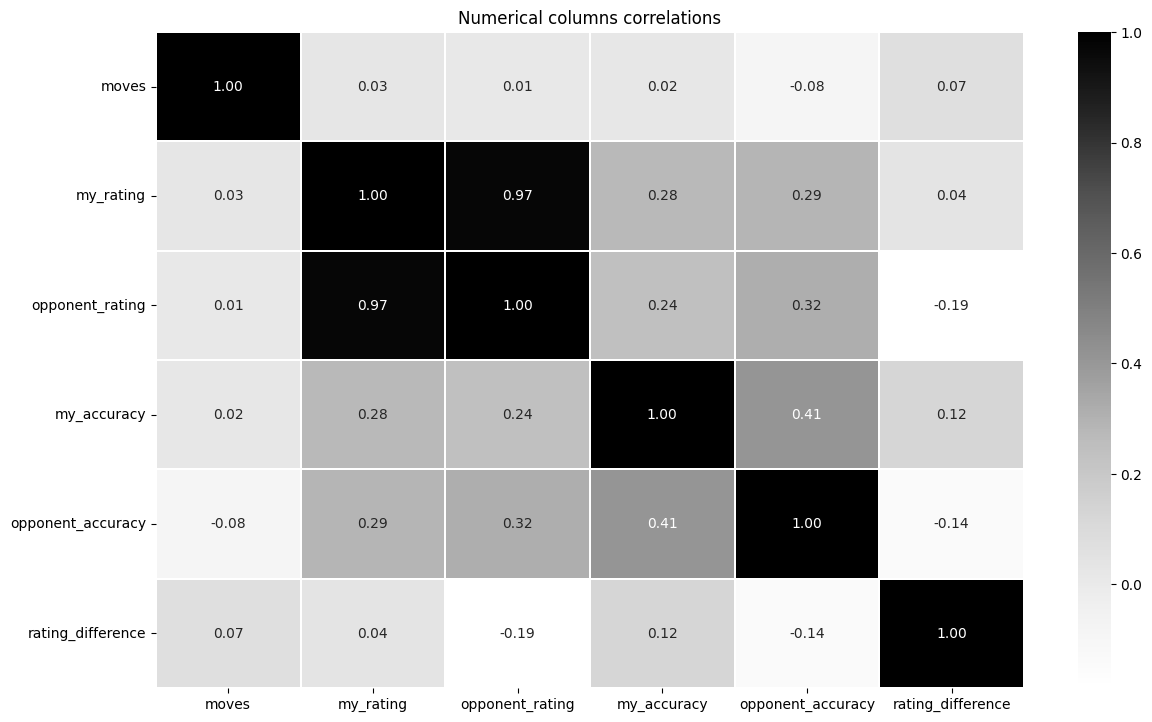

In [7]:
corr = numerical_vars_df.corr()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(corr, cmap="Greys", annot=True, fmt='.2f', linewidths=.05, ax=ax).set_title("Numerical columns correlations")
fig.subplots_adjust(top=0.93)

No alarming correlation between any of the variables, although `my_rating` and `opponent_rating` are highly correlated. If one wants to avoid using these two, one could use `rating_difference` instead for the model.

## Looking at categorical features

In [8]:
# separate the categorical features
categorical_vars = ['time_control', 'time_format', 'colour', 'outcome']
categorical_vars_df = games[categorical_vars]

categorical_vars_df.head()

,time_control,time_format,colour,outcome
0,10+0,Rapid,White,W
1,10+0,Rapid,Black,W
2,10+0,Rapid,Black,L
3,10+0,Rapid,White,W
4,10+0,Rapid,White,L


Let's see if there is any correlation between our categorical variables by doing a chi-squared test on unique pairs of categorical features.

This will enable us to remove features that might cause our model to have high variance (overfit).

In [9]:
from scipy.stats import chi2_contingency

# Create a list to store the unique pairs
unique_pairs = []

# Generate unique pairs of categorical variables
for pair in itertools.combinations(categorical_vars_df.columns, 2):
    unique_pairs.append(pair)

# Print the unique pairs
print(unique_pairs)
print('-'*100)

for pair in unique_pairs:
    var1 = pair[0]
    var2 = pair[1]
    
    contingency_table = pd.crosstab(categorical_vars_df[var1],
                                    categorical_vars_df[var2])
    stat, pval, dof, expected = chi2_contingency(contingency_table)
    
    # define alpha value below which alternative hypothesis will be accepted
    alpha = 0.05
    print(f"The p-value is {pval}.")
    if pval <= alpha:
        print(f"The variables {var1} and {var2} are correlated.")
    else:
        print(f"There is no correlation between {var1} and {var2}.")
    print("-"*50)

[('time_control', 'time_format'), ('time_control', 'colour'), ('time_control', 'outcome'), ('time_format', 'colour'), ('time_format', 'outcome'), ('colour', 'outcome')]
----------------------------------------------------------------------------------------------------
The p-value is 0.0.
The variables time_control and time_format are correlated.
--------------------------------------------------
The p-value is 0.8526675733117649.
There is no correlation between time_control and colour.
--------------------------------------------------
The p-value is 0.5167402137237589.
There is no correlation between time_control and outcome.
--------------------------------------------------
The p-value is 0.3074547321628322.
There is no correlation between time_format and colour.
--------------------------------------------------
The p-value is 0.4585825694539737.
There is no correlation between time_format and outcome.
--------------------------------------------------
The p-value is 0.94493051168

Looks like the features `time_control` and `time_format` are highly correlated, it this makes sense to remove one of these features to prevent our model(s) from overfitting.

In [10]:
print(categorical_vars_df.time_control.value_counts())

time_control
5+0      4132
10+0     2605
3+0      2308
5+5        78
1+0        23
3+2        20
30+0        7
2+1         5
15+10       3
20+0        2
Name: count, dtype: int64


Some of the values in the time control column only appear a few times (< 100) and so there is not much data on them. Since the `time_control` and `time_format` features are highly correlated, one can continue with the `time_format` feature as it provides a nice generalisation of Rapid vs Blitz vs Bullet.

In [11]:
# also drop outcome as it is our outcome variable
categorical_vars_df.drop(columns = ['time_control', 'outcome'], inplace = True)
categorical_vars_df.head()

C:\Users\zains\AppData\Local\Temp\ipykernel_49336\440317952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars_df.drop(columns = ['time_control', 'outcome'], inplace = True)


,time_format,colour
0,Rapid,White
1,Rapid,Black
2,Rapid,Black
3,Rapid,White
4,Rapid,White


#### One-hot-encoding (OHE) our categorical features for the classification model

In [12]:
categorical_vars = list(categorical_vars_df.columns)

for var in categorical_vars:
    categorical_vars_df = pd.get_dummies(categorical_vars_df, columns = [var], prefix = [var])

for col in categorical_vars_df.columns.to_list():
    categorical_vars_df[col] = categorical_vars_df[col].astype(int)
    
categorical_vars_df.head()

,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White
0,0,0,1,0,1
1,0,0,1,1,0
2,0,0,1,1,0
3,0,0,1,0,1
4,0,0,1,0,1


### Prepare `games` dataframe for classification

In [13]:
# drop time_control as it is redundant
games.drop(columns = ['time_control'], inplace = True)

# one hot encode the categorical variables
cols_to_ohe = games.loc[:,['time_format','colour']].columns.to_list()
for col in cols_to_ohe:
    games = pd.get_dummies(games, columns = [col], prefix = [col])

# make sure the boolean columns are integers containing 0 or 1
for col in games.select_dtypes(bool).columns.to_list():
    games[col] = games[col].astype(int)

# convert the outcome variable to a binary variable containing 0 or 1
games['win'] = (games.outcome == 'W').astype(int)
games.drop(columns = ['outcome'], inplace = True)

games.head()

,moves,my_rating,opponent_rating,my_accuracy,opponent_accuracy,rating_difference,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White,win
0,62,557,356,42.3,57.6,201,0,0,1,0,1,1
1,40,643,438,64.7,77.7,205,0,0,1,1,0,1
2,25,531,577,58.3,76.4,-46,0,0,1,1,0,0
3,64,625,615,81.4,77.5,10,0,0,1,0,1,1
4,12,564,639,31.6,55.5,-75,0,0,1,0,1,0


In [14]:
# normalise the numerical variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
games[numerical_vars] = scaler.fit_transform(games[numerical_vars])

games.head()

,moves,my_rating,opponent_rating,my_accuracy,opponent_accuracy,rating_difference,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White,win
0,1.961654,-2.917071,-3.667583,-1.919980,-0.815865,3.515998,0,0,1,0,1,1
1,0.478881,-2.563451,-3.336154,-0.361029,0.573475,3.587035,0,0,1,1,0,1
2,-0.532100,-3.023979,-2.774342,-0.806443,0.483617,-0.870543,0,0,1,1,0,0
3,2.096452,-2.637464,-2.620753,0.801225,0.559651,0.123976,0,0,1,0,1,1
4,-1.408284,-2.888288,-2.523750,-2.664657,-0.961020,-1.385562,0,0,1,0,1,0


In [15]:
games.to_csv('data\ML_processed.csv', index = False)